# INPUT SECTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# INPUT DATA
def setpars():
    pars={}
    pars['thetaR']=0.093
    pars['thetaS']=0.301
    pars['alpha']=5.470
    pars['n']=4.264
    pars['m']=0.76548
    pars['Ks']=5.040
    pars['Ss']=1e-6
    return pars

def setup(dt):
    # Set parameters:
    pars=setpars()

    # Grid:
    dz=0.0125
    zN=10
    tN=0.18

    z=np.arange(dz,zN,dz)
    n=len(z)

    t=np.arange(0,tN+dt,dt)
    nt=len(t)

    # Initialize array:
    psi=np.zeros((nt,n))

    # ICs:
    psi[0,:]=-z

    # BCs:
    psiT=0.1
    psiB=0

    return z,t,dz,n,nt,zN,psi,psiB,psiT,pars

# MODEL SET UP

In [2]:
# DEPENDENT VARIABLES CALCULATION
def Cfun(psi,pars):
    x3=1.+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    x6=1.+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1.-x4
    x2=x3**2.
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    x3=1.+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

def Rfun(psiiter,psiin,psiT,psiB,C,Kmid,dt,dz,n):
    # This solves the Picard residual term:
    psigrid=np.hstack([psiB,psiiter,psiT])
    x1=-C*(psiiter-psiin)/dt
    x2=1/dz**2*(Kmid[1:]*(psigrid[2:]-psigrid[1:-1])-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2]))
    x3=(Kmid[1:]-Kmid[:-1])/dz
    R=x1+x2+x3

    return R

def Jacobian(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R):
    n_nodes = len(psiiter)

    # Initialize Jacobian matrix
    J = np.zeros((n_nodes, n_nodes))

    for i in range(n_nodes):
        # Perturb psiiter[i] by a small amount
        d_psi = 1e-6
        psiiter_perturbed = psiiter.copy()
        psiiter_perturbed[i] += d_psi

        # Compute perturbed residual
        R_perturbed = Rfun(psiiter_perturbed, psiin, psiT, psiB, C, Kmid, dt, dz, n)

        # Compute column i of the Jacobian matrix
        J[:, i] = (R_perturbed - R) / d_psi

    return J


def iterfun(psiin, pars, psiT, psiB, dt, dz, n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance = 1e-10
    maxcount = 1000

    # Initialize arrays
    psiiter = np.zeros(len(psiin))
    psiout = np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:] = psiin[:]

    count = 0
    while count < maxcount:
        # Get C, K:
        C = Cfun(psiiter, pars)
        K = Kfun(np.hstack([psiB, psiiter, psiT]), pars)
        Kmid = (K[1:] + K[:-1]) / 2.

        # Get R
        R = Rfun(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n)
        J = Jacobian(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R)

        # Solve for delta psi using the Newton update formula
        delta_psi = np.linalg.solve(J, -R)

        # Update psi estimates
        psiout[:] = psiiter[:] + delta_psi[:]

        psiiter[:] = psiout[:]
        norm_delta_psi = np.linalg.norm(delta_psi)

        # Check for convergence
        if norm_delta_psi < tolerance:
            break

        count += 1
        
    return psiout

def massbal(psi,psiT,psiB,pars,n,dt,dz):
    # Initial storage:
    theta=thetafun(psi,pars)
    S=np.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=(Kfun(psiB,pars)+Kfun(psi[:,0],pars))/2.
    QIN=-Kin*((psi[:,0]-psiB)/dz+1.)
    QIN[0]=0.
    QINsum=np.sum(QIN)*dt

    # Outflow:
    Kout=(Kfun(psi[:,-1],pars)+Kfun(psiT,pars))/2.
    QOUT=-Kout*((psiT-psi[:,-1])/dz+1.)
    QOUT[0]=0.
    QOUTsum=np.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

# SIMULATION RUN

Simulation time for dt = 0.01 s: 42.2304208278656 seconds
Simulation time for dt = 0.005 s: 40.738609790802 seconds
Simulation time for dt = 0.002 s: 200.0747799873352 seconds
Simulation time for dt = 0.001 s: 422.11855959892273 seconds


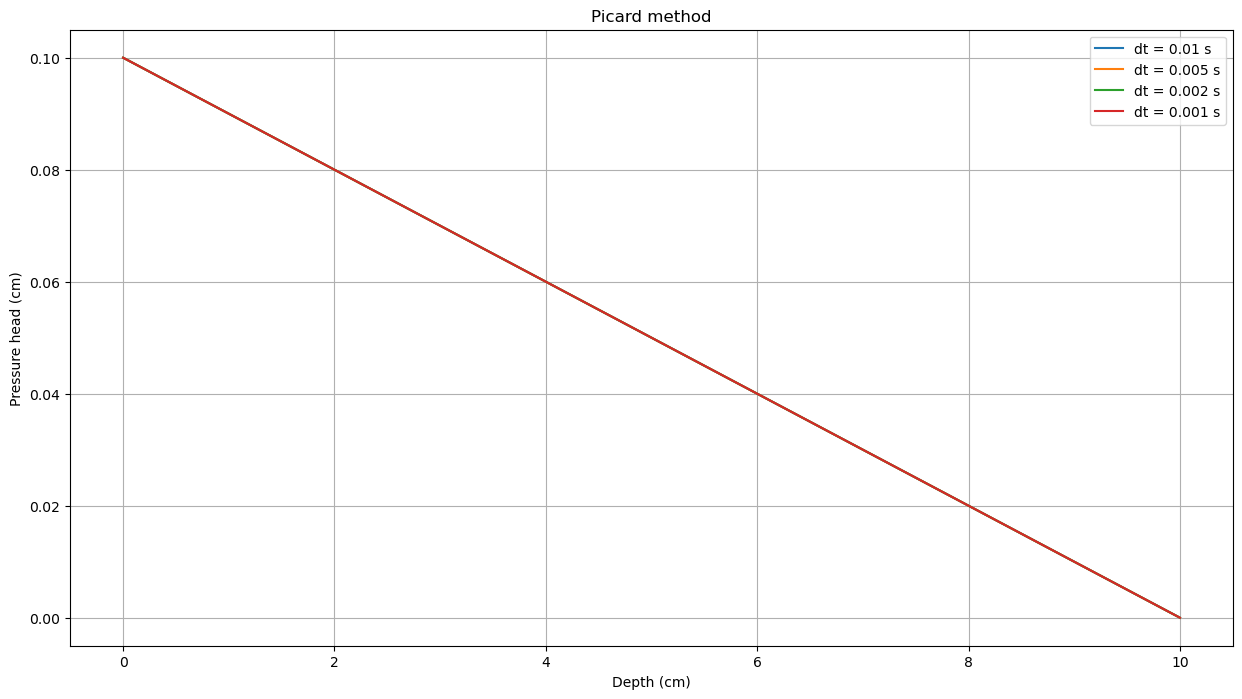

In [3]:
dt=np.array([0.01, 0.005, 0.002, 0.001]) # Define different dt values
err_values = []

psi_results = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8)) 

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)
    
    start_time = time.time()  # Record the start time 
    
    psi,QIN,QOUT,S,err=ModelRun(dti,dz,n,nt,psi,psiB,psiT,pars)
    
    # Record the end time
    end_time = time.time()
    
    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_fin = thetafun(psi,pars) # Solve for moisture content (theta)
    K_fin = Kfun(psi,pars) # Solve for hydraulic conductivity (K)

    psi_results[dti] = psi # Store psi values in the dictionary

    psi_plot = plt.plot(z, psi, label=f'dt = {dti} s') # Plot z vs psi for each dti
    
    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")

    # Append the err value for the current dt to the list
    err_values.append(err)
    
# Convert the list of err values to a numpy array for easy plotting
err_values = np.array(err_values)
    
plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

# PSI RESULTS FOR DIFFERENT TIME STEPS (dt)

In [4]:
# Convert psi_results to DataFrame
df_psi = pd.DataFrame(psi_results)

# Add the 'z' values as the first column
df_psi.insert(0, 'Depth (cm)', z)
df_psi = df_psi.iloc[::-1]

# Save DataFrame as a string and write to an Excel file
excel_file = r"Modified_Picard_results.xlsx" # Specify the name where you want to save the Excel file
df_psi.to_excel(excel_file, index=False) # Export the DataFrame to an Excel file

# RESULTS FOR ALL VARIABLES (psi, theta and K) AT LAST DEFINED TIME STEP (dt)

In [5]:
# Convert arrays to dataframes
z_df = pd.DataFrame({'Depth (cm)': z})
z_df = z_df.iloc[::-1]
psi_df = pd.DataFrame({'Head (cm)': psi})
theta_df = pd.DataFrame({'Moisture content)': theta_fin})
K_df = pd.DataFrame({'Conductivity (cm/s)': K_fin})

# Concatenate dataframes along columns
results_df = pd.concat([z_df, psi_df, theta_df, K_df], axis=1)

# Display the dataframe
print(results_df)

     Depth (cm)  Head (cm)  Moisture content)  Conductivity (cm/s)
800      0.0000   0.100000              0.301                 5.04
799      0.0125   0.099875              0.301                 5.04
798      0.0250   0.099750              0.301                 5.04
797      0.0375   0.099625              0.301                 5.04
796      0.0500   0.099500              0.301                 5.04
..          ...        ...                ...                  ...
4        9.9500   0.000500              0.301                 5.04
3        9.9625   0.000375              0.301                 5.04
2        9.9750   0.000250              0.301                 5.04
1        9.9875   0.000125              0.301                 5.04
0       10.0000   0.000000              0.301                 5.04

[801 rows x 4 columns]


# MASS BALANCE SIMULATION

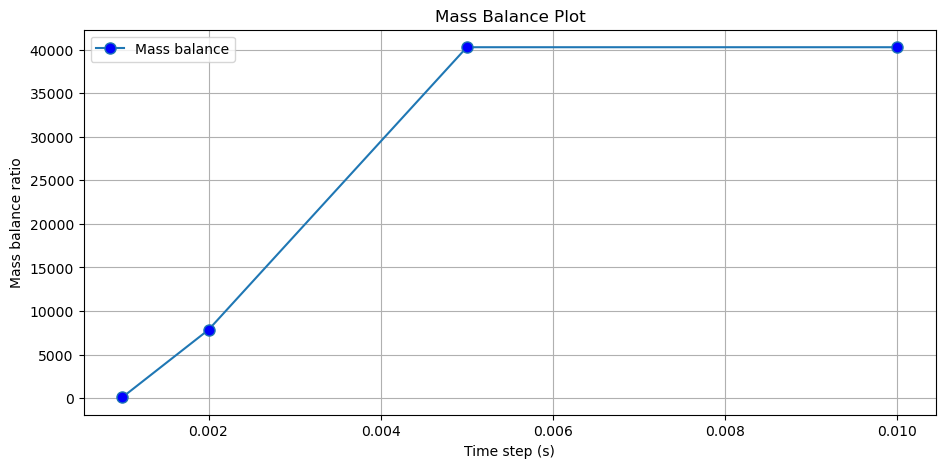

In [6]:
# Define the reference value to check closeness
reference_value = 1.0  # Reference value to compare with

# Set a tolerance level for equality
tolerance = 1e-6  # Define the tolerance level here

# Applying the condition to modify err_values
condition = np.isclose(err_values, reference_value, atol=tolerance)
err_values_modified = np.where(condition, reference_value, err_values)

# Plotting err against dt
plt.figure(figsize=(11, 5))
plt.plot(dt, err_values_modified, 'o-', label='Mass balance', markerfacecolor='blue', markersize=8)
plt.xlabel('Time step (s)')
plt.ylabel('Mass balance ratio')
plt.title('Mass Balance Plot')
plt.legend()
plt.grid(True)
plt.show()